In [1]:
import pathlib
import skimage
import cv2
import numpy as np
import pandas as pd
from skimage import feature
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
%matplotlib inline  

In [2]:
im_dir = pathlib.Path('F:/device/optics/32w_Realtime_test_5th/2')

In [3]:
temp_li = ['Low Temp', 'High Temp']
x_range = slice(400, 1900)
y_range = slice(400, 1900)
colors_li = [plt.cm.get_cmap('hsv', 30)(i) for i in range(30)]

In [4]:
ch_dict = {
    0: 'CalRed',
    1: 'FAM',
    2: 'Q670',
    3: 'HEX'
}

In [5]:
im_dict = {}
for ch in range(4):
    ch_name = ch_dict[ch]
    im_dict[ch_name] = {}
    for t in range(2):
        im_dict[ch_name][temp_li[t]] = {}
        for c in range(45):
            im_dict[ch_name][temp_li[t]][c] = {}
            fpath = im_dir/f'{c}_{t}_{ch}.jpg'
            im = np.array(Image.open(fpath))
            im_cropped = im[x_range, y_range]

            im_hsv = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2HSV)
            im_gray = im_hsv[:, :, 2]

            thresh = skimage.filters.threshold_mean(im_gray)
            threshed_im = im_gray > thresh
            im_dict[ch_name][temp_li[t]][c]['thresh'] = threshed_im

            bw = skimage.morphology.closing(threshed_im, skimage.morphology.disk(3))
            bw2 = skimage.morphology.opening(bw, skimage.morphology.disk(3))
            cleared = skimage.segmentation.clear_border(bw2)
            im_labeled = skimage.measure.label(cleared)
            im_dict[ch_name][temp_li[t]][c]['labeled'] = im_labeled
            
            region_raw_dict = {}
            for region in skimage.measure.regionprops(im_labeled, intensity_image=im_gray):
                region_raw_dict[region.area] = region
            im_dict[ch_name][temp_li[t]][c]['regions'] = region_raw_dict
        

In [6]:
result_dict = {}
for temp in temp_li:
    result_dict[temp] = {}
    for ch in ch_dict.values():
        result_dict[temp][ch] = {}

In [7]:
im_dict[ch][temp][44]['regions']

{3216: <skimage.measure._regionprops._RegionProperties at 0x2430fc623c8>,
 11858: <skimage.measure._regionprops._RegionProperties at 0x2430fc62e80>,
 11526: <skimage.measure._regionprops._RegionProperties at 0x2430fc62898>,
 12533: <skimage.measure._regionprops._RegionProperties at 0x2430fc62dd8>,
 3909: <skimage.measure._regionprops._RegionProperties at 0x2430fc62828>,
 6714: <skimage.measure._regionprops._RegionProperties at 0x2430fc62d30>,
 17296: <skimage.measure._regionprops._RegionProperties at 0x2430fc62e48>,
 16933: <skimage.measure._regionprops._RegionProperties at 0x2430fc62908>,
 10392: <skimage.measure._regionprops._RegionProperties at 0x2430fc627f0>,
 11846: <skimage.measure._regionprops._RegionProperties at 0x2430fc625f8>,
 16388: <skimage.measure._regionprops._RegionProperties at 0x2430fc62d68>,
 10339: <skimage.measure._regionprops._RegionProperties at 0x2430fc624e0>,
 16317: <skimage.measure._regionprops._RegionProperties at 0x2430fc62fd0>,
 11603: <skimage.measure._re

In [8]:
row = list('ABCD')[::-1]
result_dict = {'well_grid': {}}
for temp in temp_li:
    result_dict['well_grid'][temp] = {}

for ch in ch_dict.values():
    for temp in temp_li:
        regions = im_dict[ch][temp][44]['regions']
        
        areas_li = []
        for area, region in regions.items():
            areas_li.append(area)
            
        sorted_region_key = list(areas_li)
        sorted_region_key.sort(reverse=True)
        
        minr_li = []
        minc_li = []
        maxr_li = []
        maxc_li = []
        for key in sorted_region_key[:16]:
            region = regions[key]
            minr, minc, maxr, maxc = region.bbox
            minr_li.append(minr)
            minc_li.append(minc)
            maxr_li.append(maxr)
            maxc_li.append(maxc)
        minr_li.sort()
        top = minr_li[0]
        minc_li.sort()
        left = minc_li[0]
        maxr_li.sort()
        bottom = maxr_li[-1]
        maxc_li.sort()
        right = maxc_li[-1]

        well_box = [top-50, left-50, bottom+50, right+50]
        y_li = np.linspace(well_box[0], well_box[2], 5, endpoint=True)
        x_li = np.linspace(well_box[1], well_box[3], 5, endpoint=True)
        pts_x = []
        pts_y = []
        for x in x_li:
            for y in y_li:
                pts_x.append(x)
                pts_y.append(y)
        pts_li = list(zip(pts_x, pts_y))
        
        i = 0
        well_location_dict = {}
        for x in range(4):
            for y in range(4):
                key = row[y]+str(x+1)
                top_left_pt = pts_li[i+y+x]
                bottom_right_pt = pts_li[i+y+x+6]
                well_location_dict[key] = [top_left_pt[1], top_left_pt[0], bottom_right_pt[1], bottom_right_pt[0]]
            i += 4
        result_dict['well_grid'][temp][ch] = well_location_dict
        
            

In [9]:
result_dict['well_grid']['High Temp']['Q670']

{'D1': [97.0, 342.0, 350.75, 585.0],
 'C1': [350.75, 342.0, 604.5, 585.0],
 'B1': [604.5, 342.0, 858.25, 585.0],
 'A1': [858.25, 342.0, 1112.0, 585.0],
 'D2': [97.0, 585.0, 350.75, 828.0],
 'C2': [350.75, 585.0, 604.5, 828.0],
 'B2': [604.5, 585.0, 858.25, 828.0],
 'A2': [858.25, 585.0, 1112.0, 828.0],
 'D3': [97.0, 828.0, 350.75, 1071.0],
 'C3': [350.75, 828.0, 604.5, 1071.0],
 'B3': [604.5, 828.0, 858.25, 1071.0],
 'A3': [858.25, 828.0, 1112.0, 1071.0],
 'D4': [97.0, 1071.0, 350.75, 1314.0],
 'C4': [350.75, 1071.0, 604.5, 1314.0],
 'B4': [604.5, 1071.0, 858.25, 1314.0],
 'A4': [858.25, 1071.0, 1112.0, 1314.0]}

In [10]:
def get_well_loc(x, y, pts_center, well_location_dict):
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            radius = (x_max-x_min)/2 - 50
            pts_given = np.array([x, y])
            distance = np.linalg.norm(pts_given-pts_center)
            if distance < radius:
                return well

In [11]:
def get_grid_loc(x, y, well_location_dict):
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            return well

In [12]:
result_dict['well_grid']['High Temp']['Q670']['D1']

[97.0, 342.0, 350.75, 585.0]

In [13]:
t = 1
c = 1

sorted_region_key = list(im_dict['Q670'][temp_li[t]][c]['regions'].keys())
sorted_region_key.sort(reverse=True)

li = []
for key in sorted_region_key:
    region_obj = im_dict['Q670'][temp_li[t]][c]['regions'][key]
    y, x = region_obj.centroid
    li.append([x, y])
li.sort()
    

In [14]:
li

[[258.62672811059906, 1231.6036866359448],
 [442.46078431372547, 1388.3039215686274],
 [448.2426035502959, 1407.6331360946745],
 [463.968253968254, 1410.7777777777778],
 [468.67255859375, 280.26640625],
 [470.3122828784119, 514.9282258064516],
 [475.87347330170587, 756.597355405269],
 [544.7348439481472, 1051.3740400873608],
 [577.2801204819277, 1192.7921686746988],
 [703.0895411374299, 273.88328184002745],
 [708.8970883534137, 507.4340863453815],
 [708.9710144927536, 1191.304347826087],
 [710.3379154245335, 748.7267859114497],
 [722.7659574468086, 1175.787234042553],
 [934.327507350539, 267.46711314385277],
 [940.4994219158139, 505.3414550593072],
 [944.041107295244, 741.7530440212302],
 [945.1191123412248, 970.3113725102555],
 [1000.7551020408164, 103.92517006802721],
 [1166.9065647482014, 263.1539568345324],
 [1166.938563520809, 957.7478985853892],
 [1168.1680274753758, 736.8747407983411],
 [1169.7601942315569, 500.61112736207804]]

In [15]:
for x, y in li:
    grid = get_grid_loc(x, y, result_dict['well_grid']['High Temp']['Q670'])
    print(grid, '>>>', x, y)

None >>> 258.62672811059906 1231.6036866359448
None >>> 442.46078431372547 1388.3039215686274
None >>> 448.2426035502959 1407.6331360946745
None >>> 463.968253968254 1410.7777777777778
D1 >>> 468.67255859375 280.26640625
C1 >>> 470.3122828784119 514.9282258064516
B1 >>> 475.87347330170587 756.597355405269
A1 >>> 544.7348439481472 1051.3740400873608
None >>> 577.2801204819277 1192.7921686746988
D2 >>> 703.0895411374299 273.88328184002745
C2 >>> 708.8970883534137 507.4340863453815
None >>> 708.9710144927536 1191.304347826087
B2 >>> 710.3379154245335 748.7267859114497
None >>> 722.7659574468086 1175.787234042553
D3 >>> 934.327507350539 267.46711314385277
C3 >>> 940.4994219158139 505.3414550593072
B3 >>> 944.041107295244 741.7530440212302
A3 >>> 945.1191123412248 970.3113725102555
D3 >>> 1000.7551020408164 103.92517006802721
D4 >>> 1166.9065647482014 263.1539568345324
A4 >>> 1166.938563520809 957.7478985853892
B4 >>> 1168.1680274753758 736.8747407983411
C4 >>> 1169.7601942315569 500.611127

In [16]:
region_sum_dict = {}
for t in range(2):
    temp = temp_li[t]
    region_sum_dict[temp] = {}
    for ch in ch_dict.values():
        region_sum_dict[temp][ch] = {}
        for well in well_location_dict.keys():
            region_sum_dict[temp][ch][well] = [0]*45

        for c in range(45):
            sorted_region_key = list(im_dict[ch][temp][c]['regions'].keys())
            sorted_region_key.sort(reverse=True)

            center_at_cycle = {}
            for key in sorted_region_key:
                region_obj = im_dict[ch][temp][c]['regions'][key]
                y, x = region_obj.centroid
                grid = get_grid_loc(x, y, result_dict['well_grid'][temp][ch])
                if grid is None:
                    continue
            
                if grid not in center_at_cycle.keys():
                    center = [x, y]
                    center_at_cycle[grid] = center
                else:
                    center = center_at_cycle[grid]
                well = get_well_loc(x, y, center, result_dict['well_grid'][temp][ch])

                if well is not None:
                    val = region_sum_dict[temp][ch][well][c]
                    val += region_obj.intensity_image.sum()
                    region_sum_dict[temp][ch][well][c] = val

result_dict['rfu_sum'] = region_sum_dict


In [17]:
ch_dict.values()

dict_values(['CalRed', 'FAM', 'Q670', 'HEX'])

In [18]:
dict_before = pd.read_excel('F:/device/optics/32w_Realtime_test_5th/5차 2번카메라.xlsx', sheet_name=None, header=None)
dict_before.keys()

odict_keys(['fam60', 'hex60', 'cal60', 'qua60', 'fam72', 'hex72', 'cal72', 'qua72'])

In [19]:
df = dict_before['fam60']
df

0       1       2       3       4       5       6       7       8   \
0   45841  122714  115249   47317  159241  354639  360273  159439  217330   
1   43353  116732  112159   46362  149806  338644  352249  158645  205554   
2   45011  122730  114589   46271  150569  342402  353387  160476  204505   
3   43897  124110  117059   45744  147735  339499  351869  161300  199116   
4   43311  123093  116435   44464  144758  335128  350619  160355  196681   
5   31191   98474   99840   37459  124177  307261  323422  151217  183874   
6   31628  105131  101799   37672  122126  303434  321620  152215  182142   
7   30875  103588  102367   37854  121517  303578  320172  153096  179439   
8   30402  104079  103481   37183  120726  300185  318065  151311  178150   
9   29934  103800  104377   35991  119772  299734  318194  152334  176492   
10  29293  102885  104478   34589  117247  298880  317068  151771  175497   
11  29647  102049  103796   33380  117223  296149  317512  151649  173169   
12  29922  102939  106518   34482  116100  295130  314883  151220  174100   
13  29666  100954  106761   33680  115127  292644  312467  149898  173124   
14  29096  101773  106813   33765  115023  292895  310190  147951  171816   
15  28806  100342  107214   33782  114039  291975  312184  149547  170679   
16  27884  100425  106361   33221  112331  287501  307732  148870  171159   
17  27588  100437  106970   33886  111896  287728  307865  147905  169649   
18  27765   99110  108314   33348  112520  286749  307214  149026  168287   
19  27647  100504  107134   34013  110913  286731  305908  147854  168411   
20  27044   98627  105557   33808  109961  283909  304754  146834  166088   
21  27406   94256  104612   34147  110547  283073  303956  146528  166944   
22  27284   93584  105242   33998  109430  281012  303709  146317  165594   
23  27928   92691  106548   34067  108535  281946  301988  146010  167387   
24  27420   94055  104756   34815  108640  280270  302645  143403  165775   
25  26724   91330  104926   34162  108272  278595  300995  143729  163441   
26  26793   93011  104515   33816  107918  277802  299252  143817  164154   
27  27155   92279  104131   34033  108233  279409  303195  143488  164183   
28  26296   93090  105036   33632  108323  279046  301134  143431  163945   
29  26441   93664  105619   34955  108295  280049  304676  144730  164209   
30  26597   94107  107341   35053  108669  280838  308246  146718  164415   
31  27154   95531  109732   35454  110515  285669  314304  151203  166526   
32  27695   98610  112691   36757  111748  289476  322809  154831  169670   
33  28846  100972  119491   38929  116747  300360  336877  162557  173696   
34  29847  105139  124283   40707  121137  309467  345679  167746  181549   
35  31804  115376  132316   43473  124683  322059  361691  178486  186866   
36  33901  122465  138858   46909  135056  336194  379886  187257  198125   
37  36707  132742  150134   51254  141770  354307  403731  198111  205635   
38  36388  143986  168619   65703  145983  386086  452858  229784  214699   
39  41066  158039  182936   72926  158607  412113  483222  247717  227118   
40  46620  174309  198071   80013  173168  441800  514001  265386  241679   
41  56928  200979  230864   97650  202536  496174  573760  303142  279821   
42  63025  215882  248103  107564  216563  521270  599146  322193  298733   
43  68074  225932  261414  114369  229829  542243  622186  337259  313804   

        9       10      11      12      13      14      15  
0   411200  387879  173026  151721  316275  317554  185391  
1   399409  386515  176443  150016  319358  322322  188086  
2   402995  378857  174305  151727  320317  323005  184624  
3   399747  377233  175199  151718  323114  325385  186847  
4   396073  376349  173881  151105  321844  324471  188692  
5   381807  384910  175358  150932  332446  337118  195266  
6   381293  390261  174429  148718  331193  336435  193579  
7   380587  389988  174696  149942  335531  338766  1

In [20]:
len(df)

44

In [21]:
map_dict = {
    'CalRed': 'cal',
    'FAM': 'fam',
    'HEX': 'hex',
    'Q670': 'qua',
    'L': '60',
    'H': '72'
}
row = list('ABCD')[::-1]
col_li = []
for y in range(4):
    for x in range(4):
        key = row[y]+str(x+1)
        col_li.append(key)
col_li

['D1',
 'D2',
 'D3',
 'D4',
 'C1',
 'C2',
 'C3',
 'C4',
 'B1',
 'B2',
 'B3',
 'B4',
 'A1',
 'A2',
 'A3',
 'A4']

In [22]:
result_dict['rfu_sum']['Low Temp'].keys()

dict_keys(['CalRed', 'FAM', 'Q670', 'HEX'])

In [23]:
pd.DataFrame(result_dict['rfu_sum']['High Temp']['Q670'])

D1      C1      B1       A1      D2      C2      B2      A2      D3  \
0   128598  264064  355551  1211747  259362  375462  346436       0  247070   
1   134562  259890  351740  1301052  264389  372842  348881       0  259090   
2   136045  261876  346237  1304197  276229  376154  350623       0  265525   
3   136091  258856  345475  1469228  273165  376193  352904       0  275433   
4   132781  212674  270588   280486  261103  352638  329249  294311  265420   
5        0  220414  276774   283633     966  375770  348525  303228     219   
6   160942  205187  266399   274045     332  360141  349032  298781    3674   
7     5618  204796  264590   273184     795  364271  350997  301267    1036   
8        0  211554  268580   287447     969  368237  349510  305380    2200   
9   154581  200254  262215   277763  287207  353991  348527  302791       0   
10  155053  198027  260619   277951  283879  353858  346589  305659    4575   
11    5381  200516  261089   280186    1825  355655  346515  308800     897   
12       0  206262  263255   289026    1954  363390  342294  305144     412   
13  166037  195227  253490   274372     290  357197  337709  297633    1376   
14    1323  205495  259811   286040       0  364831  339776  306573    1191   
15  159006  192625  256480   279047    5053  346193  335848  301762       0   
16  157235  193225  252747   282355    2925  346692  333276  305129     665   
17  160261  189920  254462   274375     287  349950  334003  300178    4956   
18    8499  193154  252602   283397     217  349752  330782  308731       0   
19  152864  190318  252174   281927     476  345014  331177  304946    1627   
20  166101  192307  249733   282317    2640  347132  330911  306591     810   
21     836  190719  248461   280649    1420  347285  329803  302117    2085   
22     958  189200  248448   278915     778  347837  328705  302691     235   
23    3157  202168  258489   300424     506  348054  324241  315854    2061   
24    1793  201948  257042   303193     690  352844  322675  313919    1172   
25       0  200762  258879   301390    2933  355426  323683  311245    3263   
26  161485  200654  256398   303863    1966  349187  322086  317490    4297   
27  162072  200310  255462   308373  288564  352711  321803  315743    2957   
28     721  201394  258045   302833  293411  360316  325765  312348    2753   
29  165770  201829  258795   309365  296824  359985  325195  317421  330827   
30  172351  203120  262100   304029    3642  364091  330167  315939     860   
31  165453  210449  267146   313632  293827  374072  340147  322060    2918   
32  174024  218793  268470   316604  311133  385431  351219  331185    4706   
33  163456  220282  274593   317500  298622  388620  363842  340004  343141   
34  180136  234265  289828   331451  316733  406989  387067  355486  364754   
35  201192  252870  313035   343428  348463  437284  413707  369064  379683   
36  205995  266143  317638   359911  352594  449753  437059  398979  403490   
37  217825  286384  347953   382346  377609  479473  470866  413420  429252   
38  228320  299614  368470   403011  415818  536287  516595  450025  473263   
39  251952  320341  382172   421255  441376  563346  542046  473509  500567   
40  229036  321951  397462   425227  415902  568969  560631  487797  454878   
41  282950  355663  426938   455548  481957  605599  582737  511294       0   
42  297066  369124  440741   475721  511433  623471  595784  530838    1506   
43  305309  381259  449469   485270  516205  639577  596436  536334       0   
44  264221  370417  446484   485261  463395  621182  596833  546684  496098   

        C3      B3      A3      D4      C4      B4      A4  
0   421344  339612  345514  134999  267665  235484  246024  
1   421520  343965  358894  135286  275247  245281  252741  
2   424173  344820  359128  141057  279291  240095  243803  
3   427775  347400  367982  148889  287074  251097  257941  
4   371364  295144  285244  161518  244299  198562  202916  
5   399

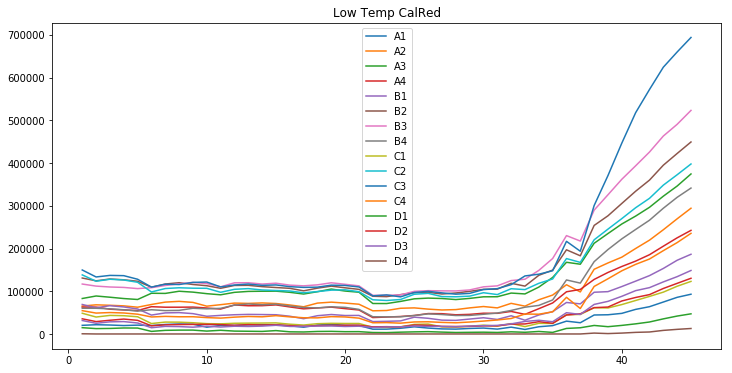

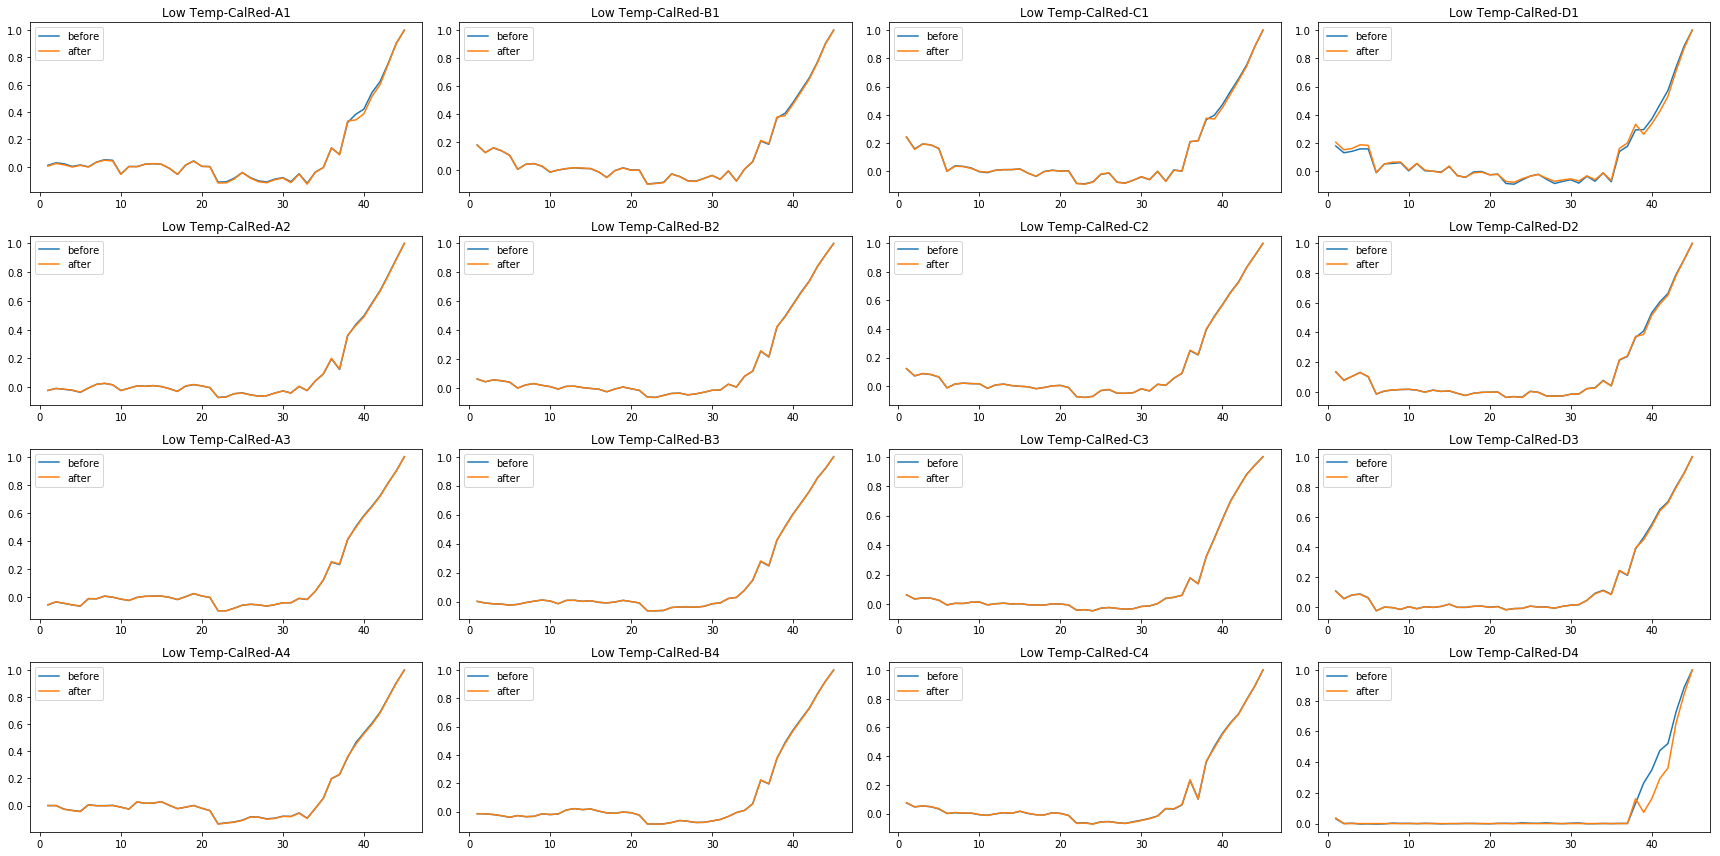

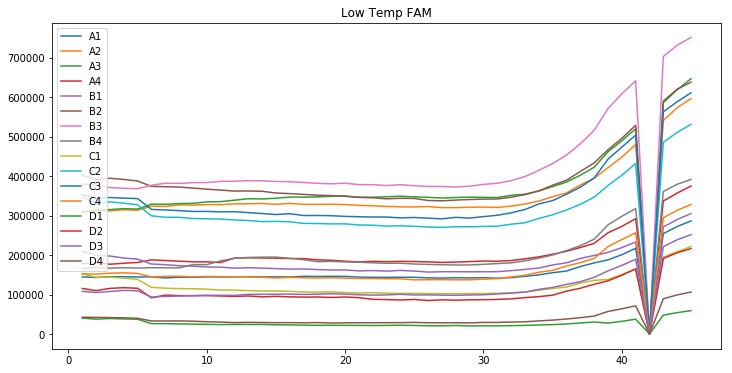

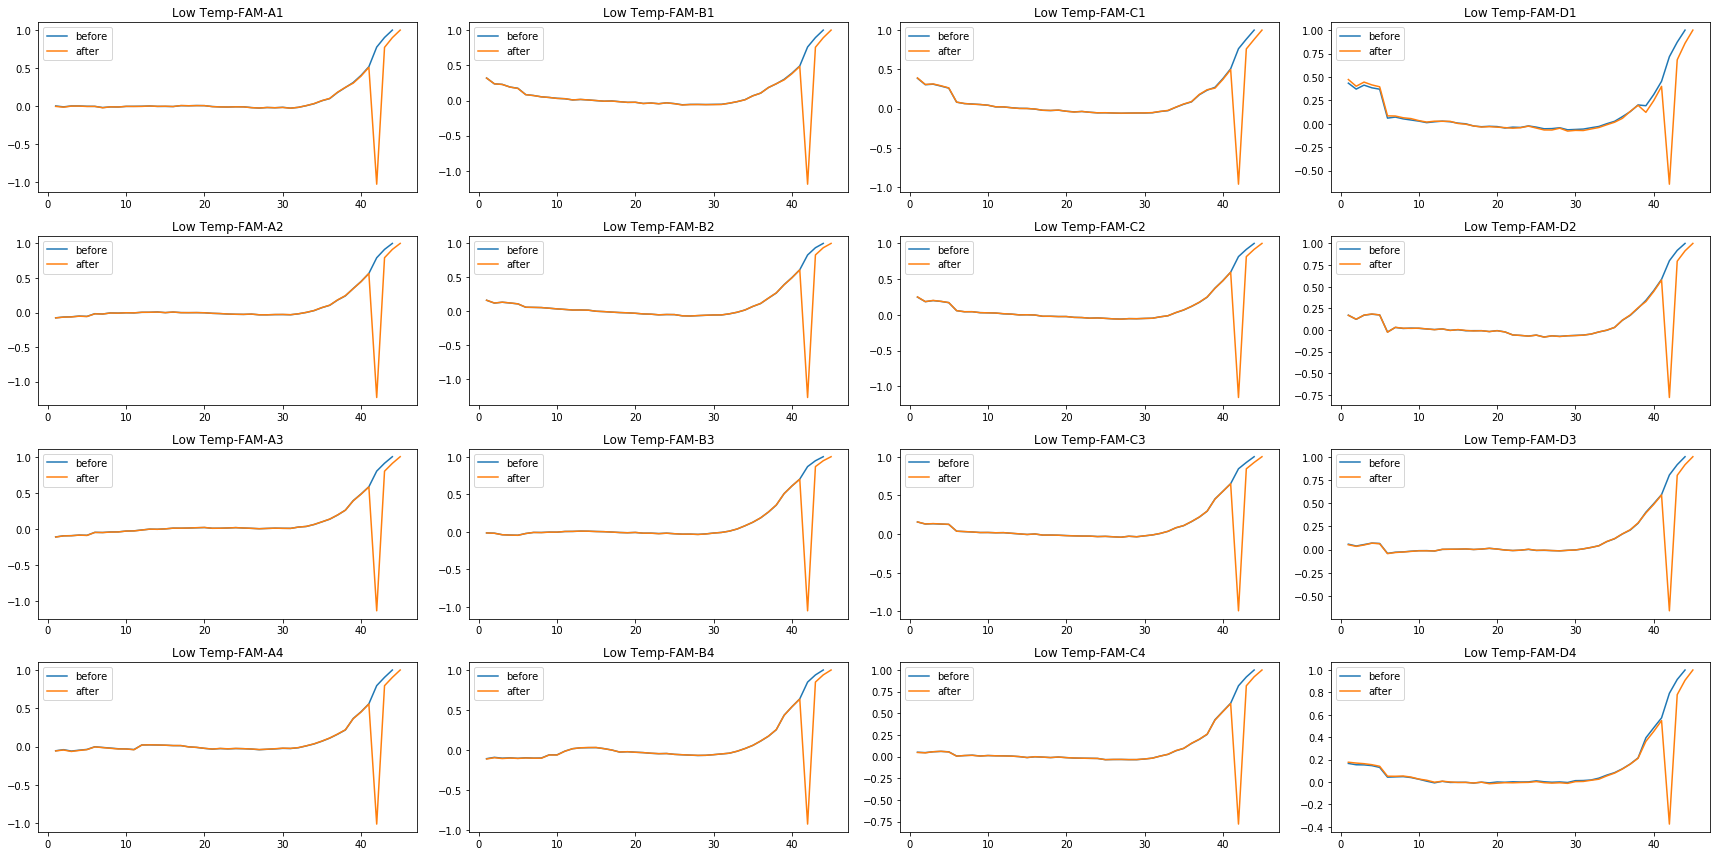

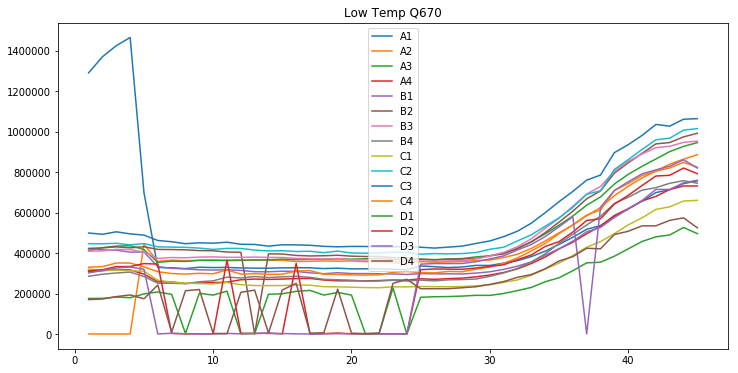

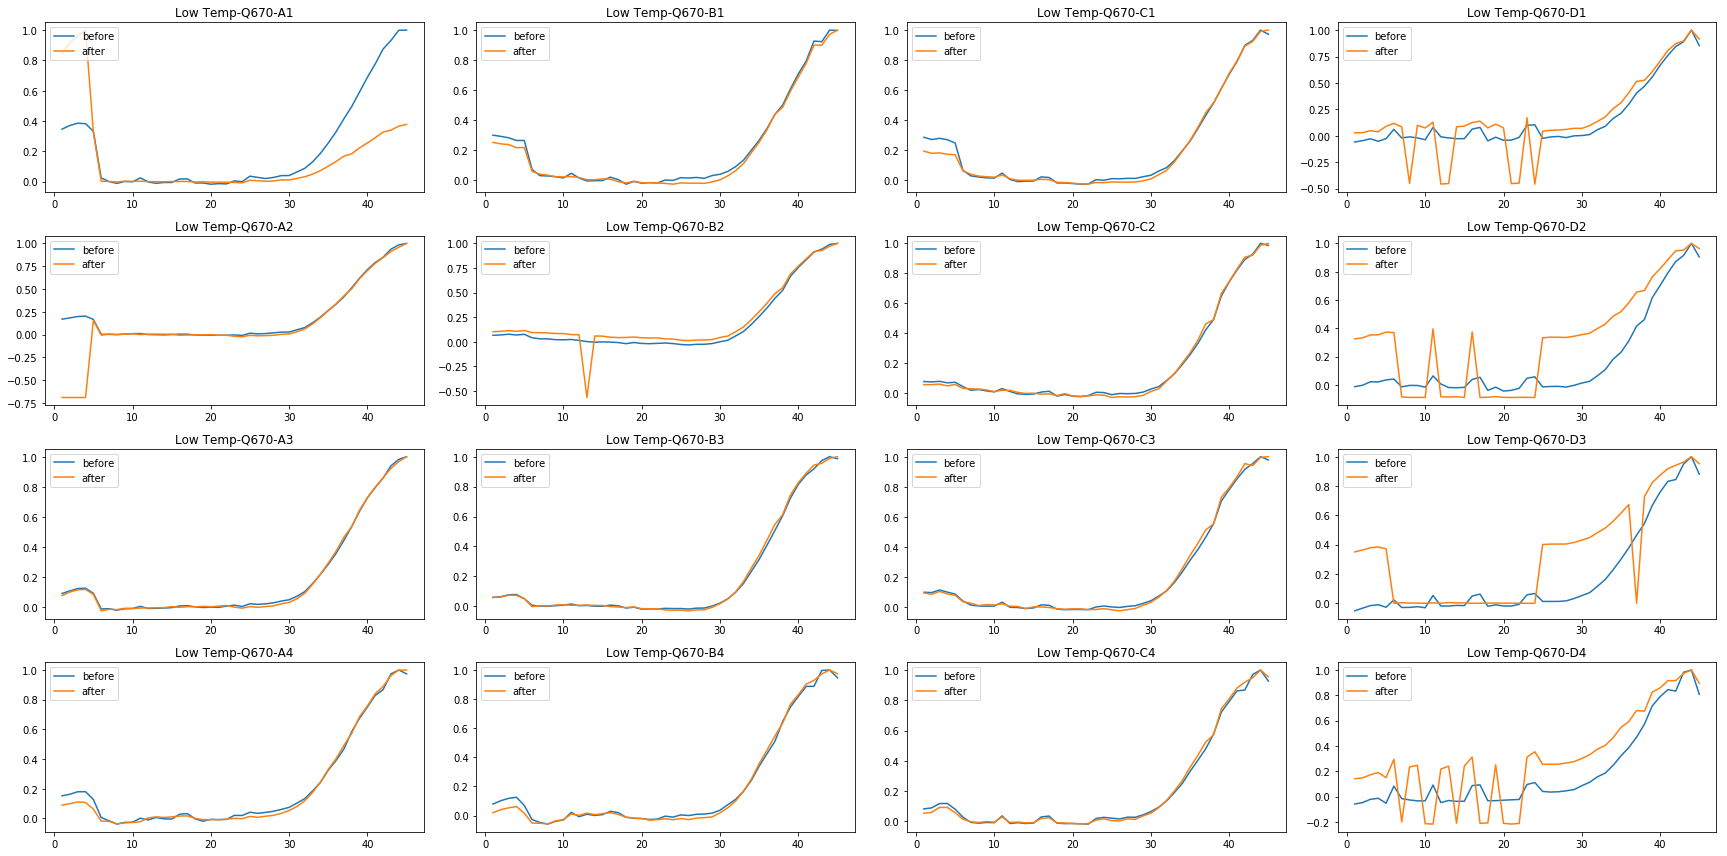

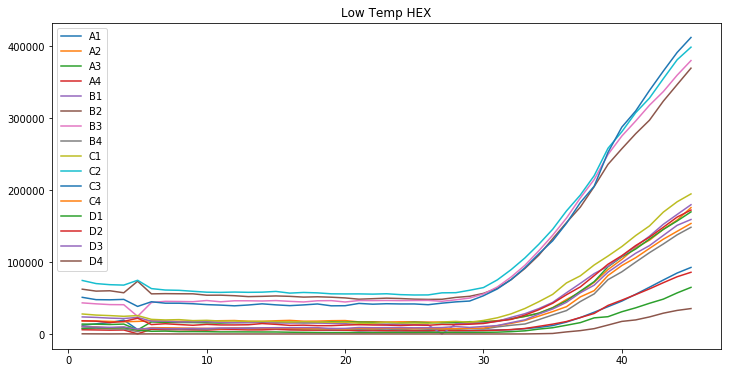

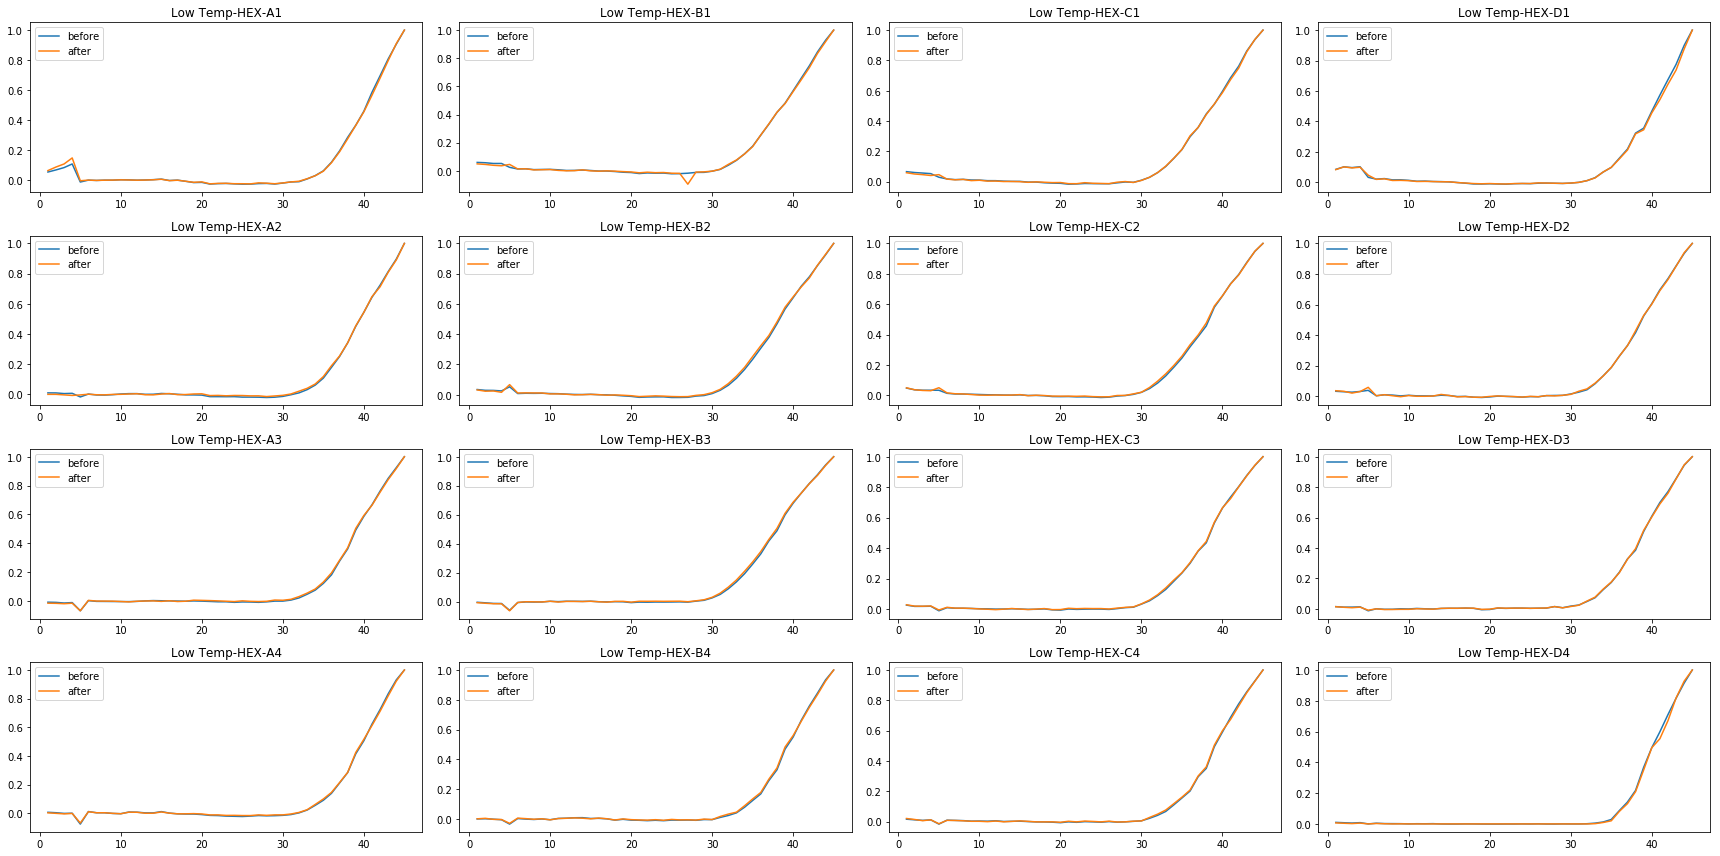

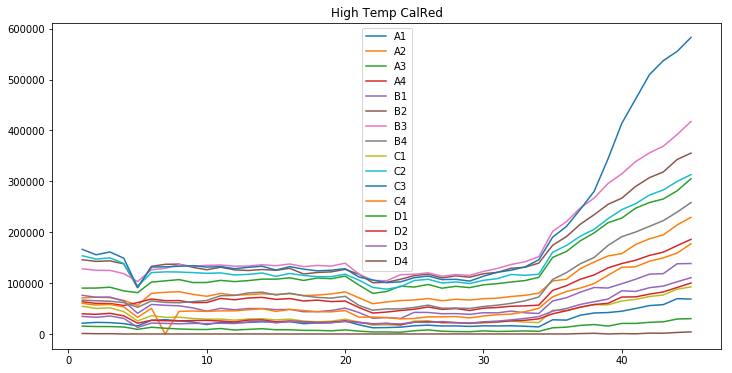

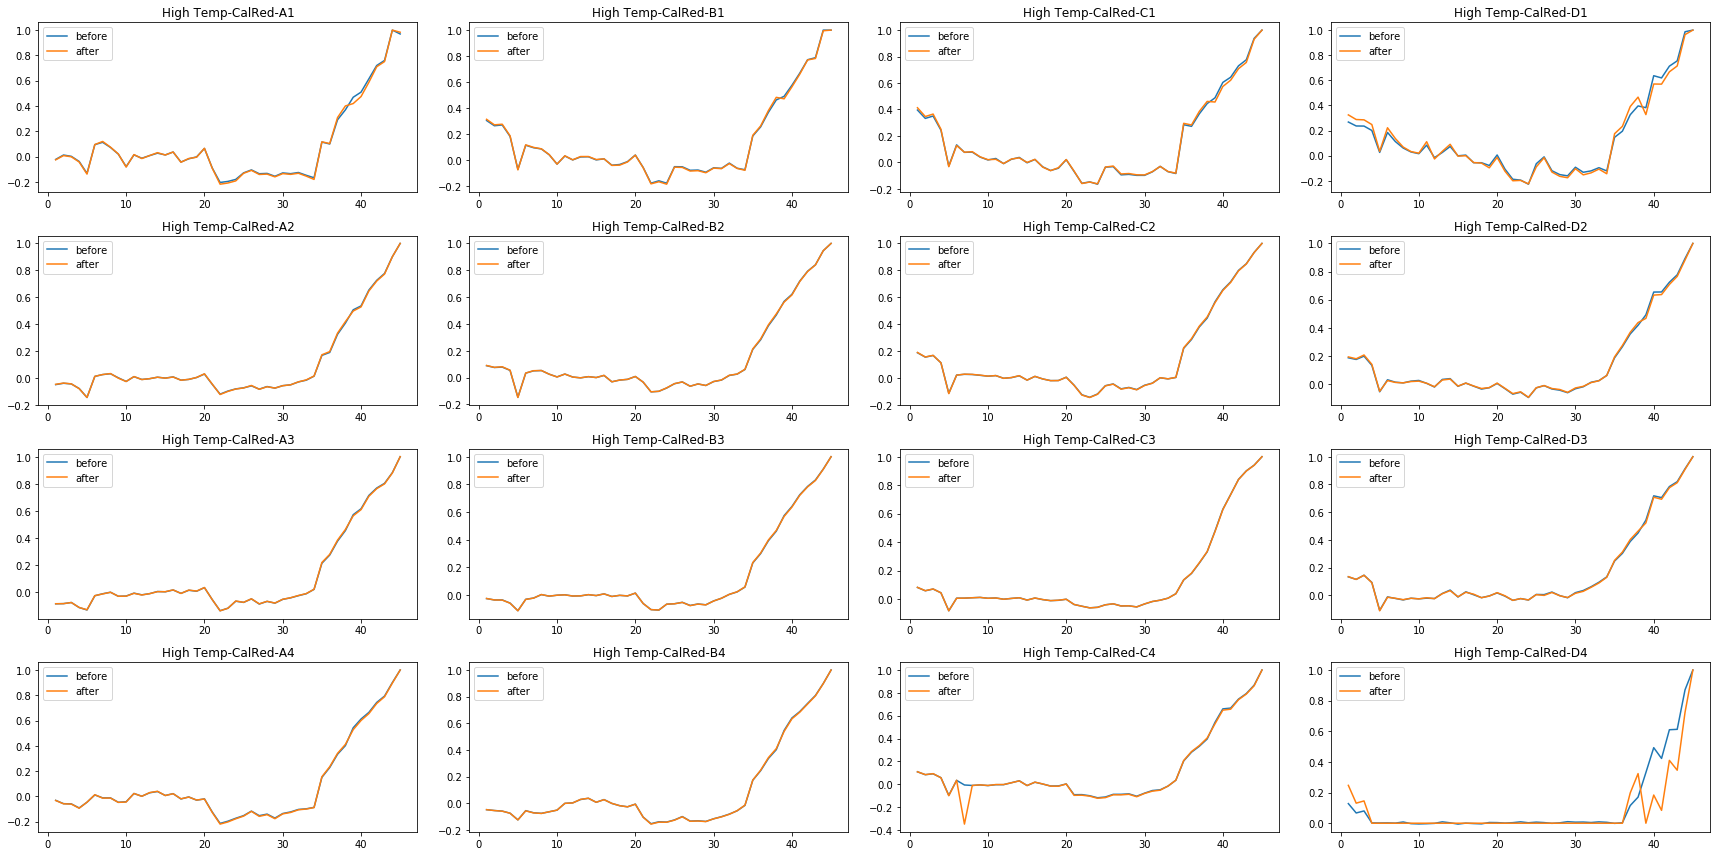

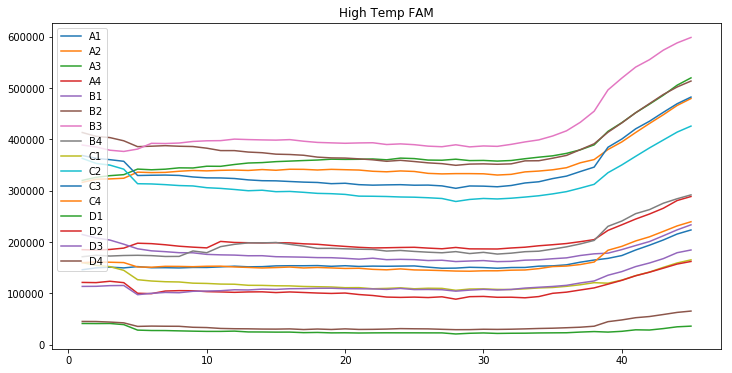

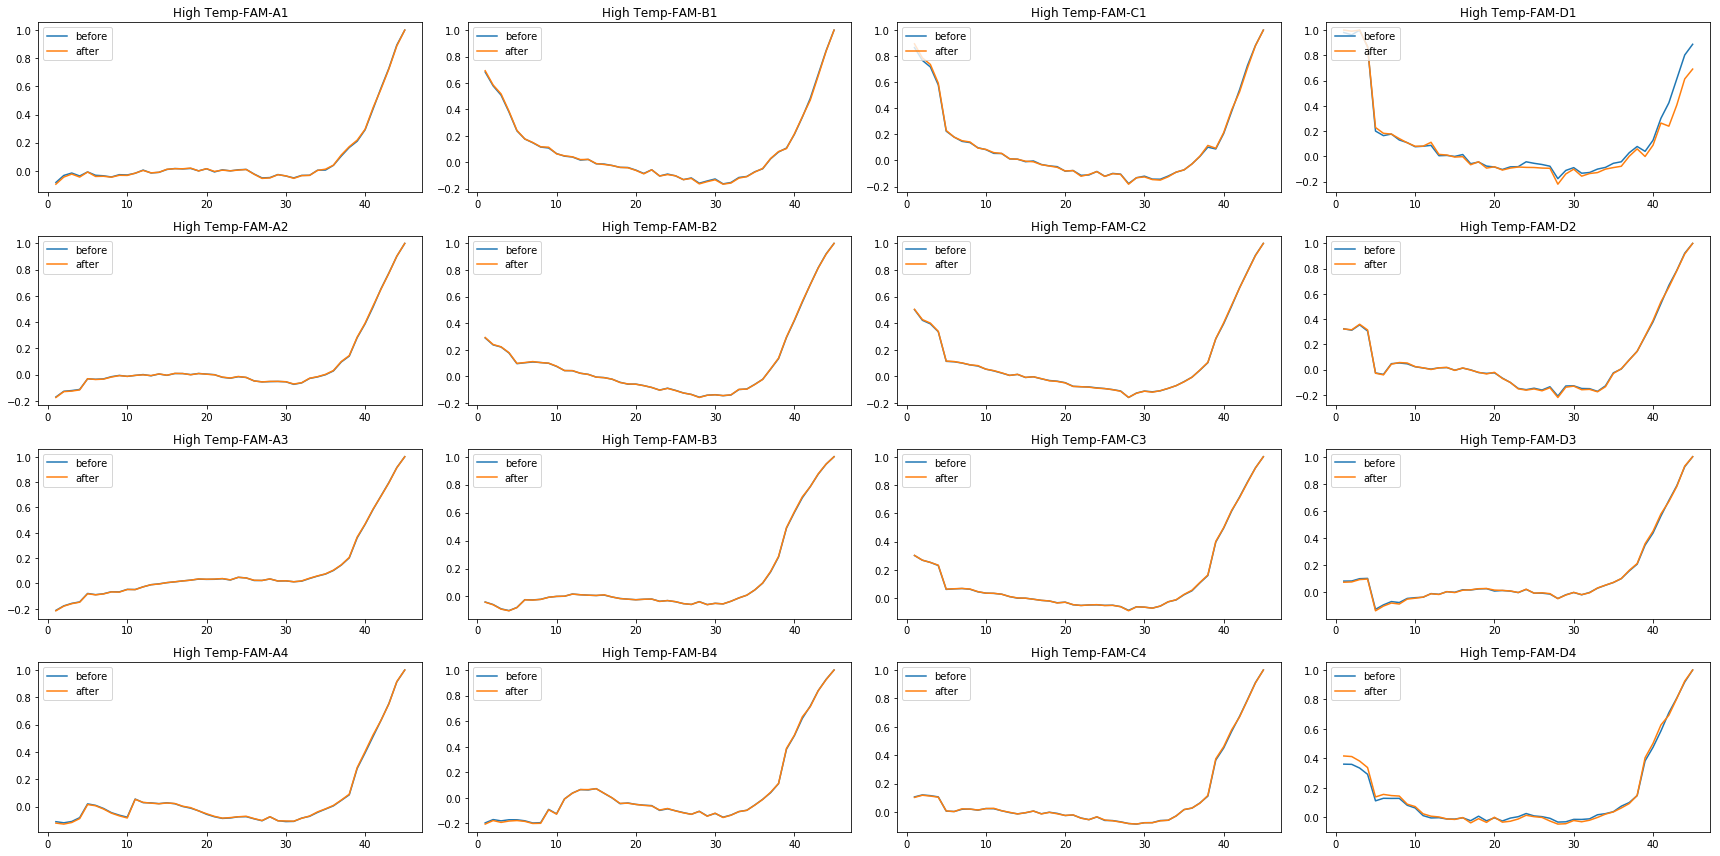

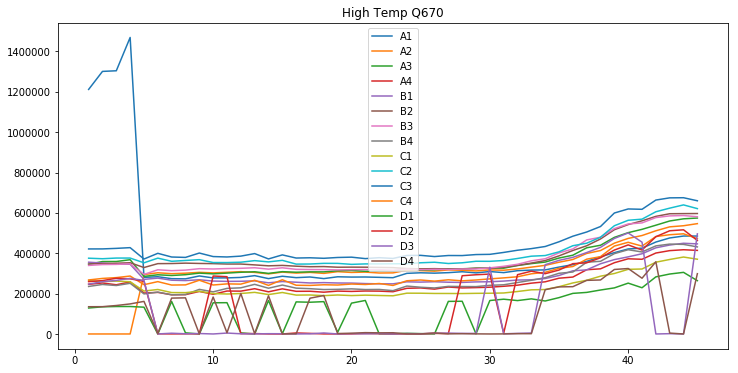

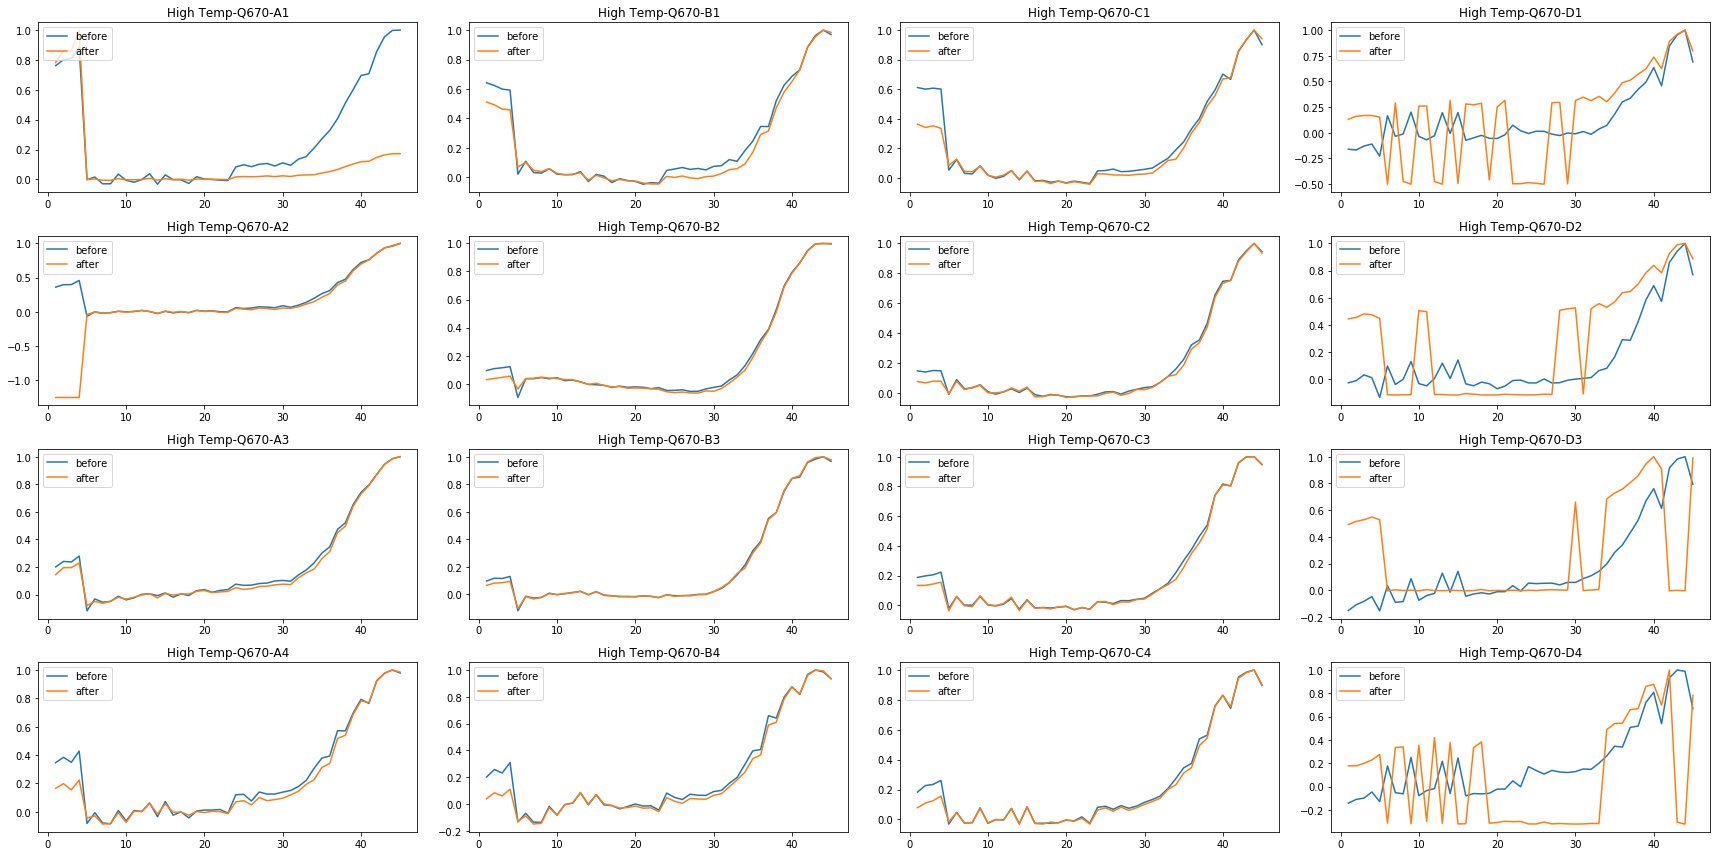

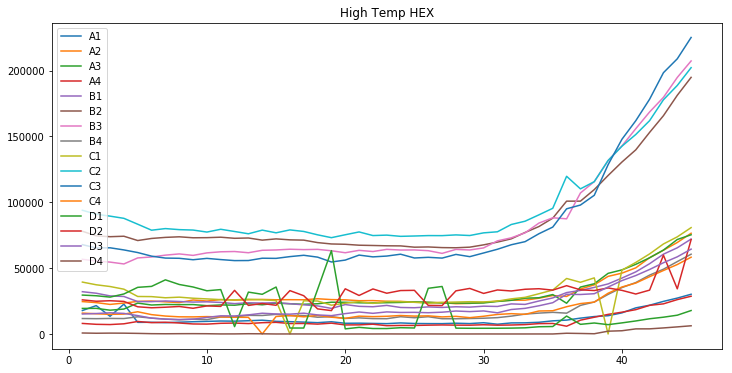

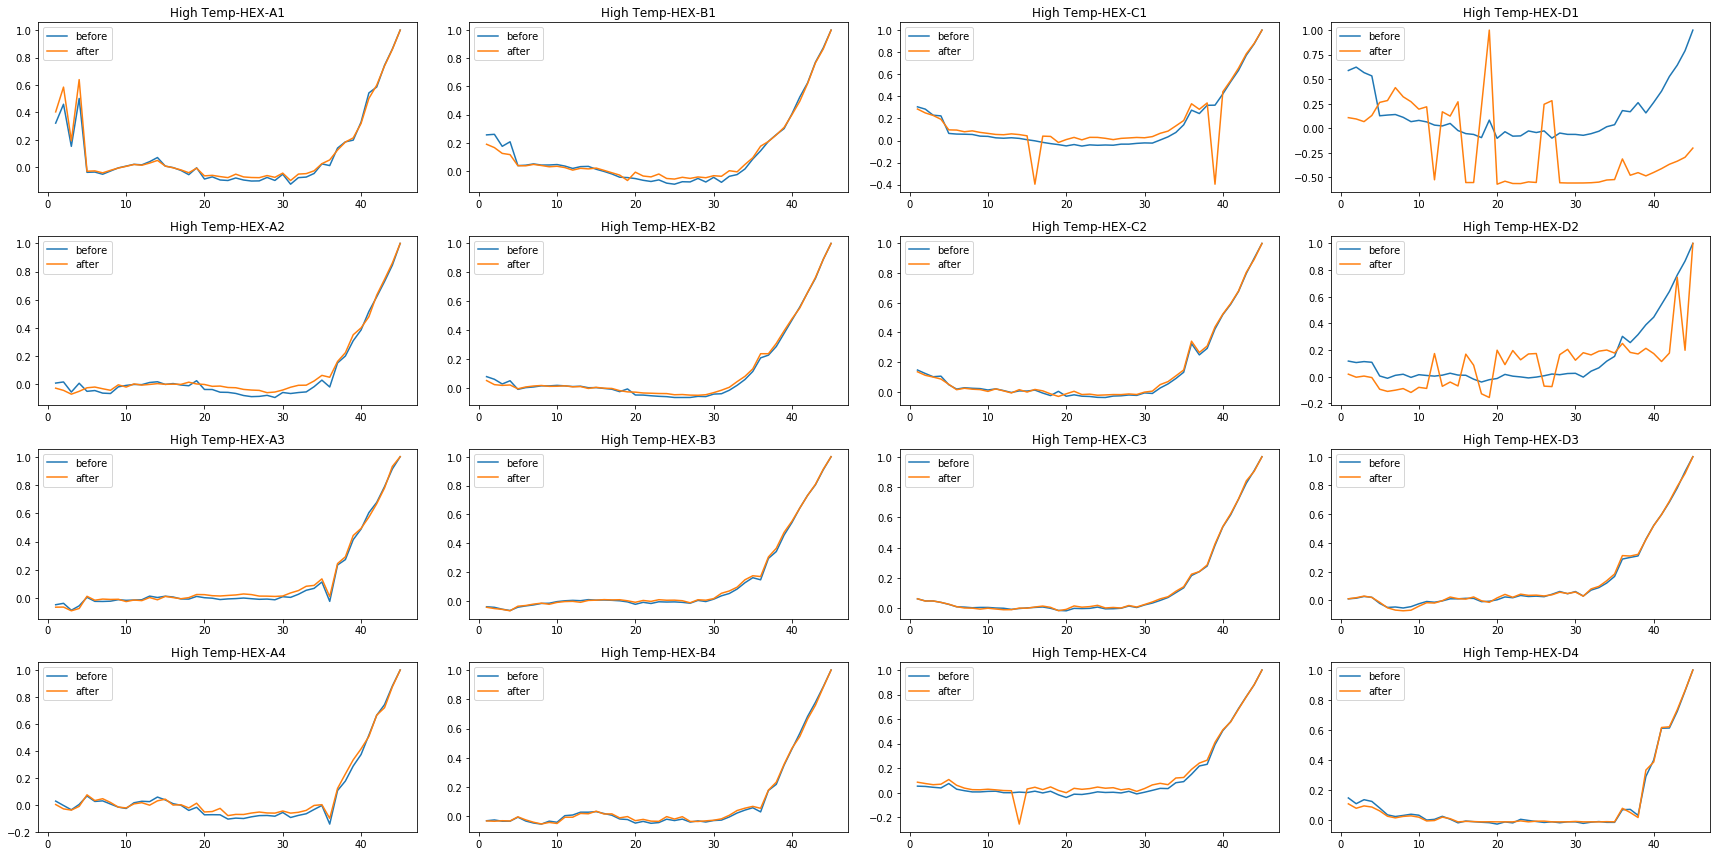

In [24]:
for temp in result_dict['rfu_sum'].keys():
    for ch, _dict in result_dict['rfu_sum'][temp].items():
        df = pd.DataFrame(_dict)
        df.index = range(1, 46)
        df = df.reindex(sorted(df.columns), axis=1)
        fig = df.plot(figsize=(12, 6), title=f'{temp} {ch}').get_figure()
        fig.savefig(f'camera2_mean_hsv_{temp}_{ch}.png')
        
        key_before = map_dict[ch]+map_dict[temp[0]]
        df_before = dict_before[key_before]
        df_before.columns = col_li
        df_before.index = range(1, len(df_before)+1)
        
        df_before_norm = (df_before - df_before.loc[10:20].mean())/(df_before.max()-df_before.loc[10:20].mean())
        df_norm = (df-df.loc[10:20].mean())/(df.max()-df.loc[10:20].mean())
        
        fig, axes = plt.subplots(4, 4, figsize=(24, 12))
        n = 0
        for col in df_norm.columns:
            i = n%4
            j = n//4
            axes[i, j].plot(df_before_norm[col], label='before')
            axes[i, j].plot(df_norm[col], label='after')
            axes[i, j].set_title(f'{temp}-{ch}-{col}')
            n += 1
            axes[i, j].legend(loc='upper left')
        plt.tight_layout()
        plt.savefig(f'camera2_hsv_mean_compare_{temp}_{ch}.png')

# investigate High Q670

In [25]:
import matplotlib.patches as _patches

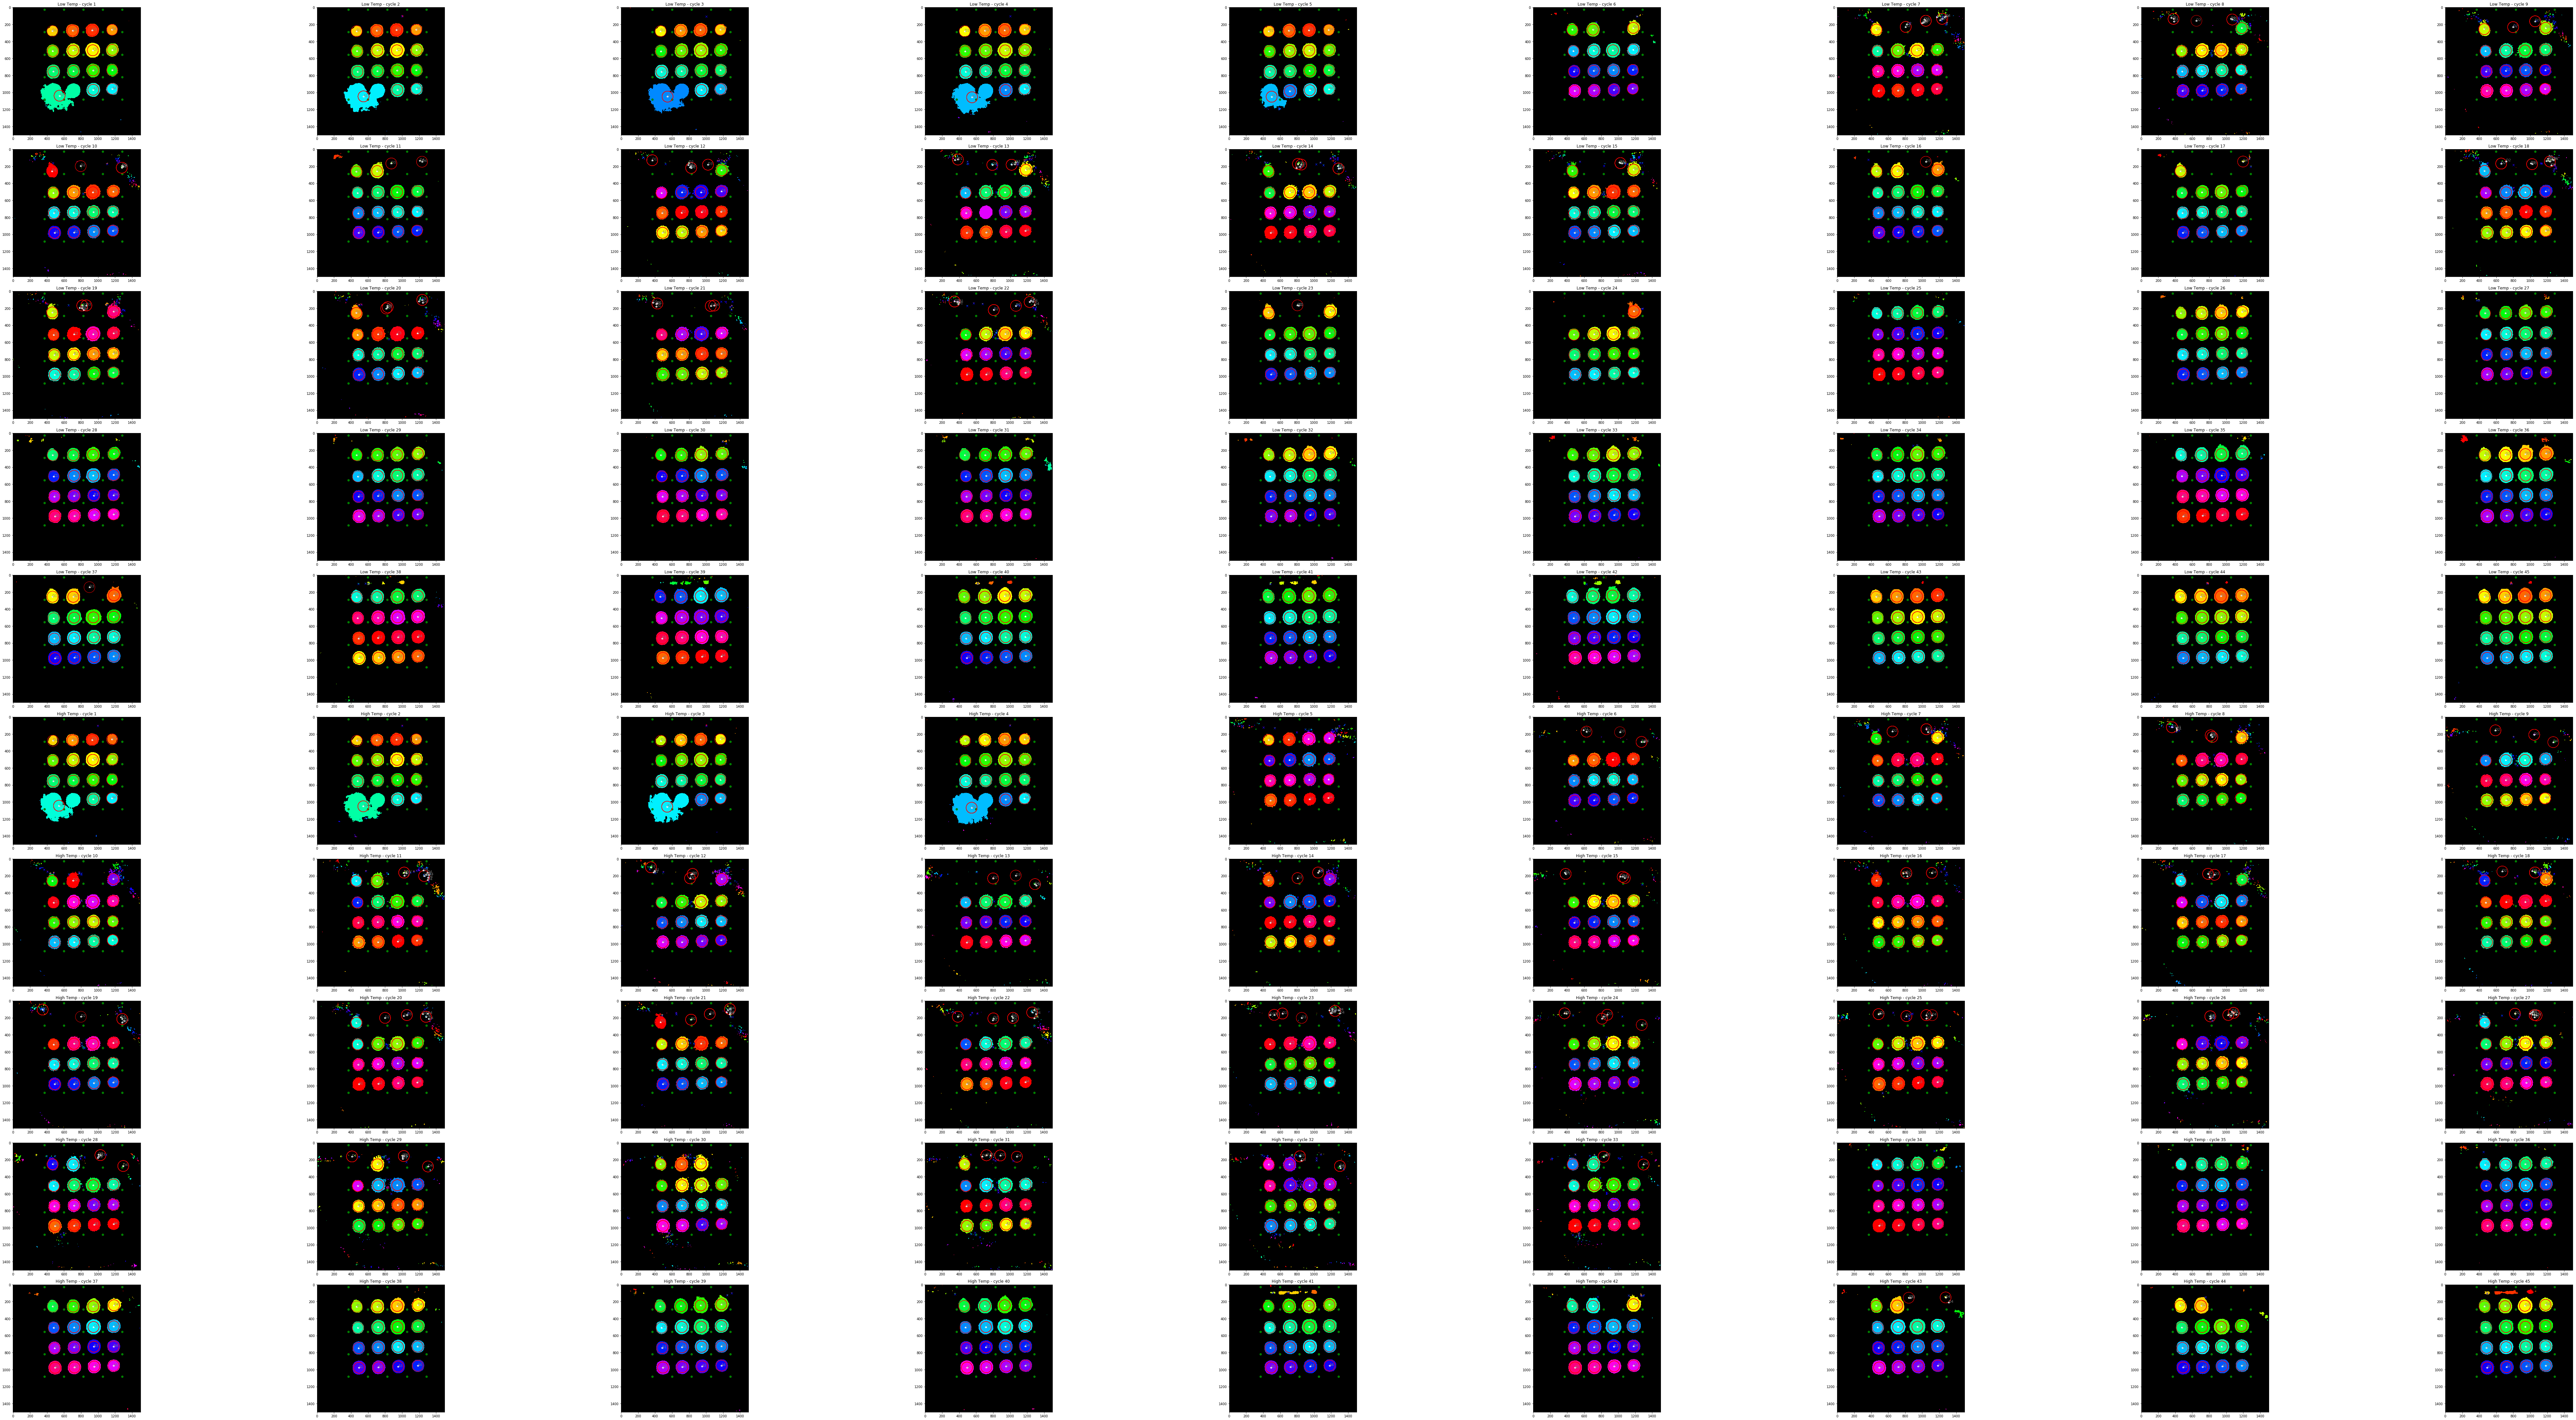

In [26]:
fig, ax = plt.subplots(10, 9, figsize=(24*5, 12*5))            
region_intensity_dict = {}
for t in range(2):
    region_intensity_dict[temp_li[t]] = {}
    for well in well_location_dict.keys():
        region_intensity_dict[temp_li[t]][well] = [0]*45
        
    for c in range(45):
        im_labeled = im_dict['Q670'][temp_li[t]][c]['labeled']
        image_label_overlay = skimage.color.label2rgb(im_labeled, bg_label=0, colors=colors_li)
        ax_x_coord = c//9+(t*5)
        ax_y_coord = c%9
        
        ax[ax_x_coord, ax_y_coord].imshow(image_label_overlay)
        ax[ax_x_coord, ax_y_coord].set_title(f'{temp_li[t]} - cycle {c+1}')
        ax[ax_x_coord, ax_y_coord].scatter(pts_x, pts_y, c='g')
        
        sorted_region_key = list(im_dict['Q670'][temp_li[t]][c]['regions'].keys())
        sorted_region_key.sort(reverse=True)
                
        center_at_cycle = {}
        circle_li = []
        for key in sorted_region_key:
            region_obj = im_dict['Q670'][temp_li[t]][c]['regions'][key]
            y, x = region_obj.centroid
            grid = get_grid_loc(x, y, result_dict['well_grid'][temp_li[t]]['Q670'])
            if grid is None:
                continue
            
            if grid not in center_at_cycle.keys():
                center = [x, y]
                center_at_cycle[grid] = center

                y_min, x_min, y_max, x_max = well_location_dict[grid]
                grid_center_x = (x_max-x_min)/2 + x_min
                rad = grid_center_x - x_min - 50
                circle_li.append(_patches.Circle(center, radius=rad, color='r', fill=False, linewidth=1))
            else:
                center = center_at_cycle[grid]
            well = get_well_loc(x, y, center, result_dict['well_grid'][temp_li[t]]['Q670'])

            if well is not None:
                val = region_intensity_dict[temp_li[t]][well][c]
                val += region_obj.intensity_image.sum()
                region_intensity_dict[temp_li[t]][well][c] = val

                ax[ax_x_coord, ax_y_coord].plot(x, y, color='white', marker='*')
                ax[ax_x_coord, ax_y_coord].text(x, y, well, color='gray')
            else:
                ax[ax_x_coord, ax_y_coord].plot(x, y, color='b', marker='x')
            for circle in circle_li:
                ax[ax_x_coord, ax_y_coord].add_artist(circle)

plt.tight_layout()
plt.savefig('hsv_mean_camera2_q670_circle.png')
plt.show()

In [27]:
df_high_q = pd.DataFrame(region_intensity_dict['High Temp'])

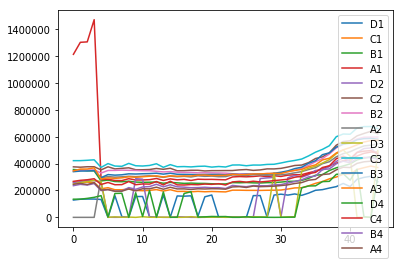

In [28]:
pd.DataFrame(region_intensity_dict['High Temp']).plot()

In [29]:
df_before = dict_before['qua72']
df_before.columns = col_li
df_before.index = range(1, len(df_before)+1)

In [30]:
df_high_q.index = range(1, 46)
df_high_q = df_high_q.reindex(sorted(df_high_q.columns), axis=1)

df_before_norm = (df_before - df_before.loc[10:20].mean())/(df_before.max()-df_before.loc[10:20].mean())
df_high_q_norm = (df_high_q-df_high_q.loc[10:20].mean())/(df_high_q.max()-df_high_q.loc[10:20].mean())

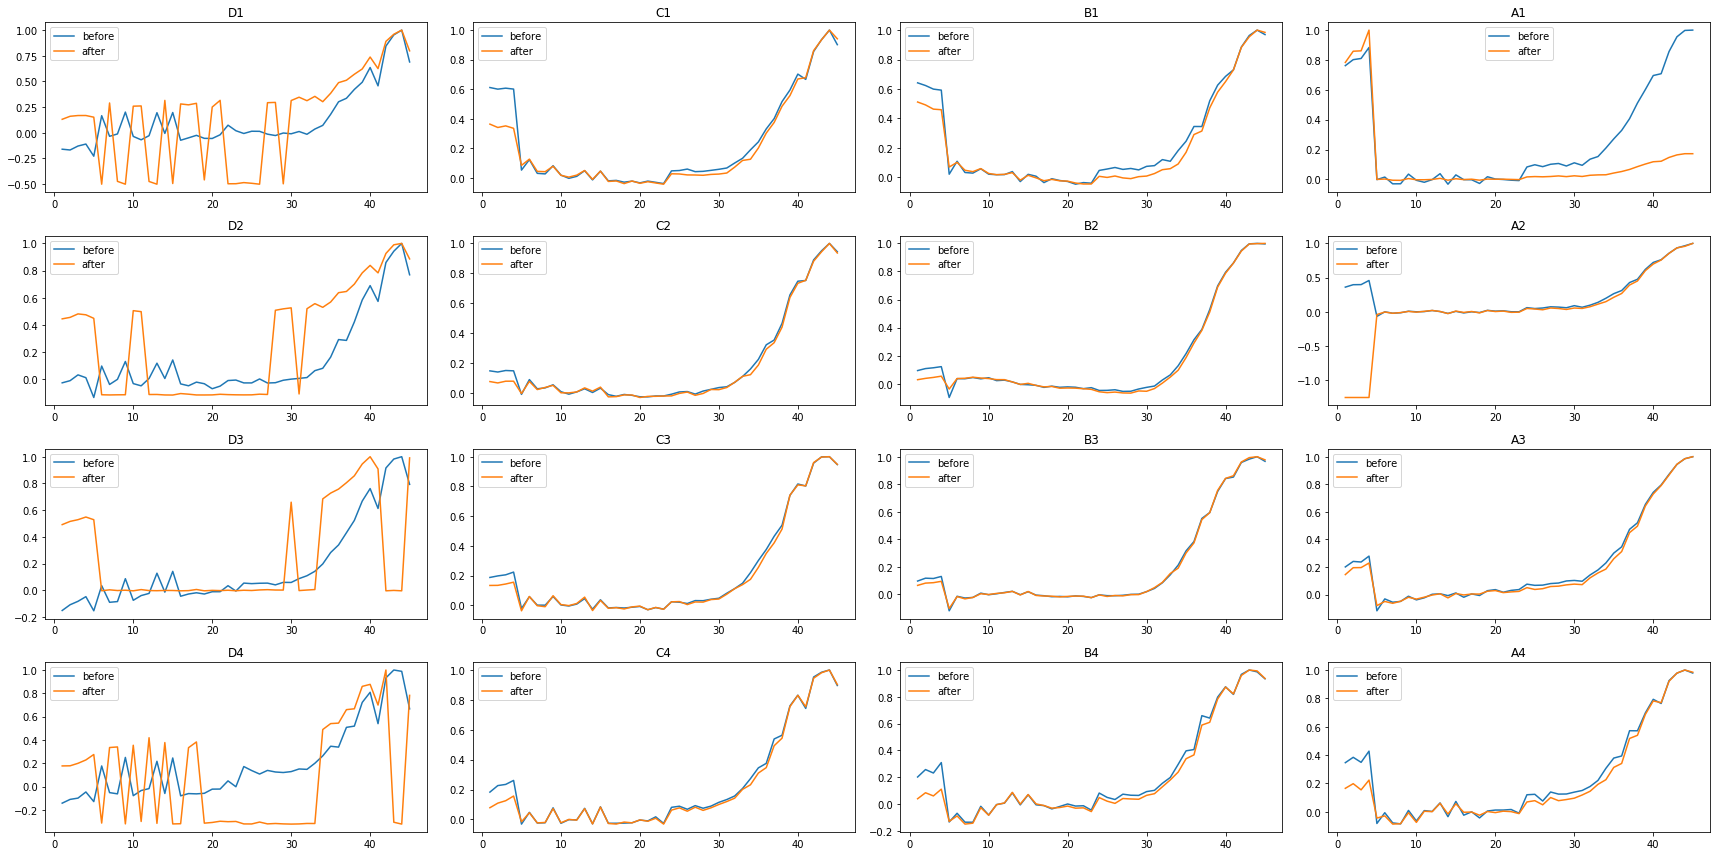

In [31]:
fig, axes = plt.subplots(4, 4, figsize=(24, 12))
n = 0
for col in df_before_norm.columns:
    i = n%4
    j = n//4
    axes[i, j].plot(df_before_norm[col], label='before')
    axes[i, j].plot(df_high_q_norm[col], label='after')
    axes[i, j].set_title(col)
    n += 1
    axes[i, j].legend(loc='best')
plt.tight_layout()
plt.savefig('compare_mean_hsv_high_quasar_.png')
plt.show()

# Low Cal Red

In [62]:
pts_x = []
pts_y = []
for key, val in result_dict['well_grid']['Low Temp']['CalRed'].items():
    y1, x1, y2, x2 = val
    pts_x.extend([x1, x2])
    pts_y.extend([y1, y2])

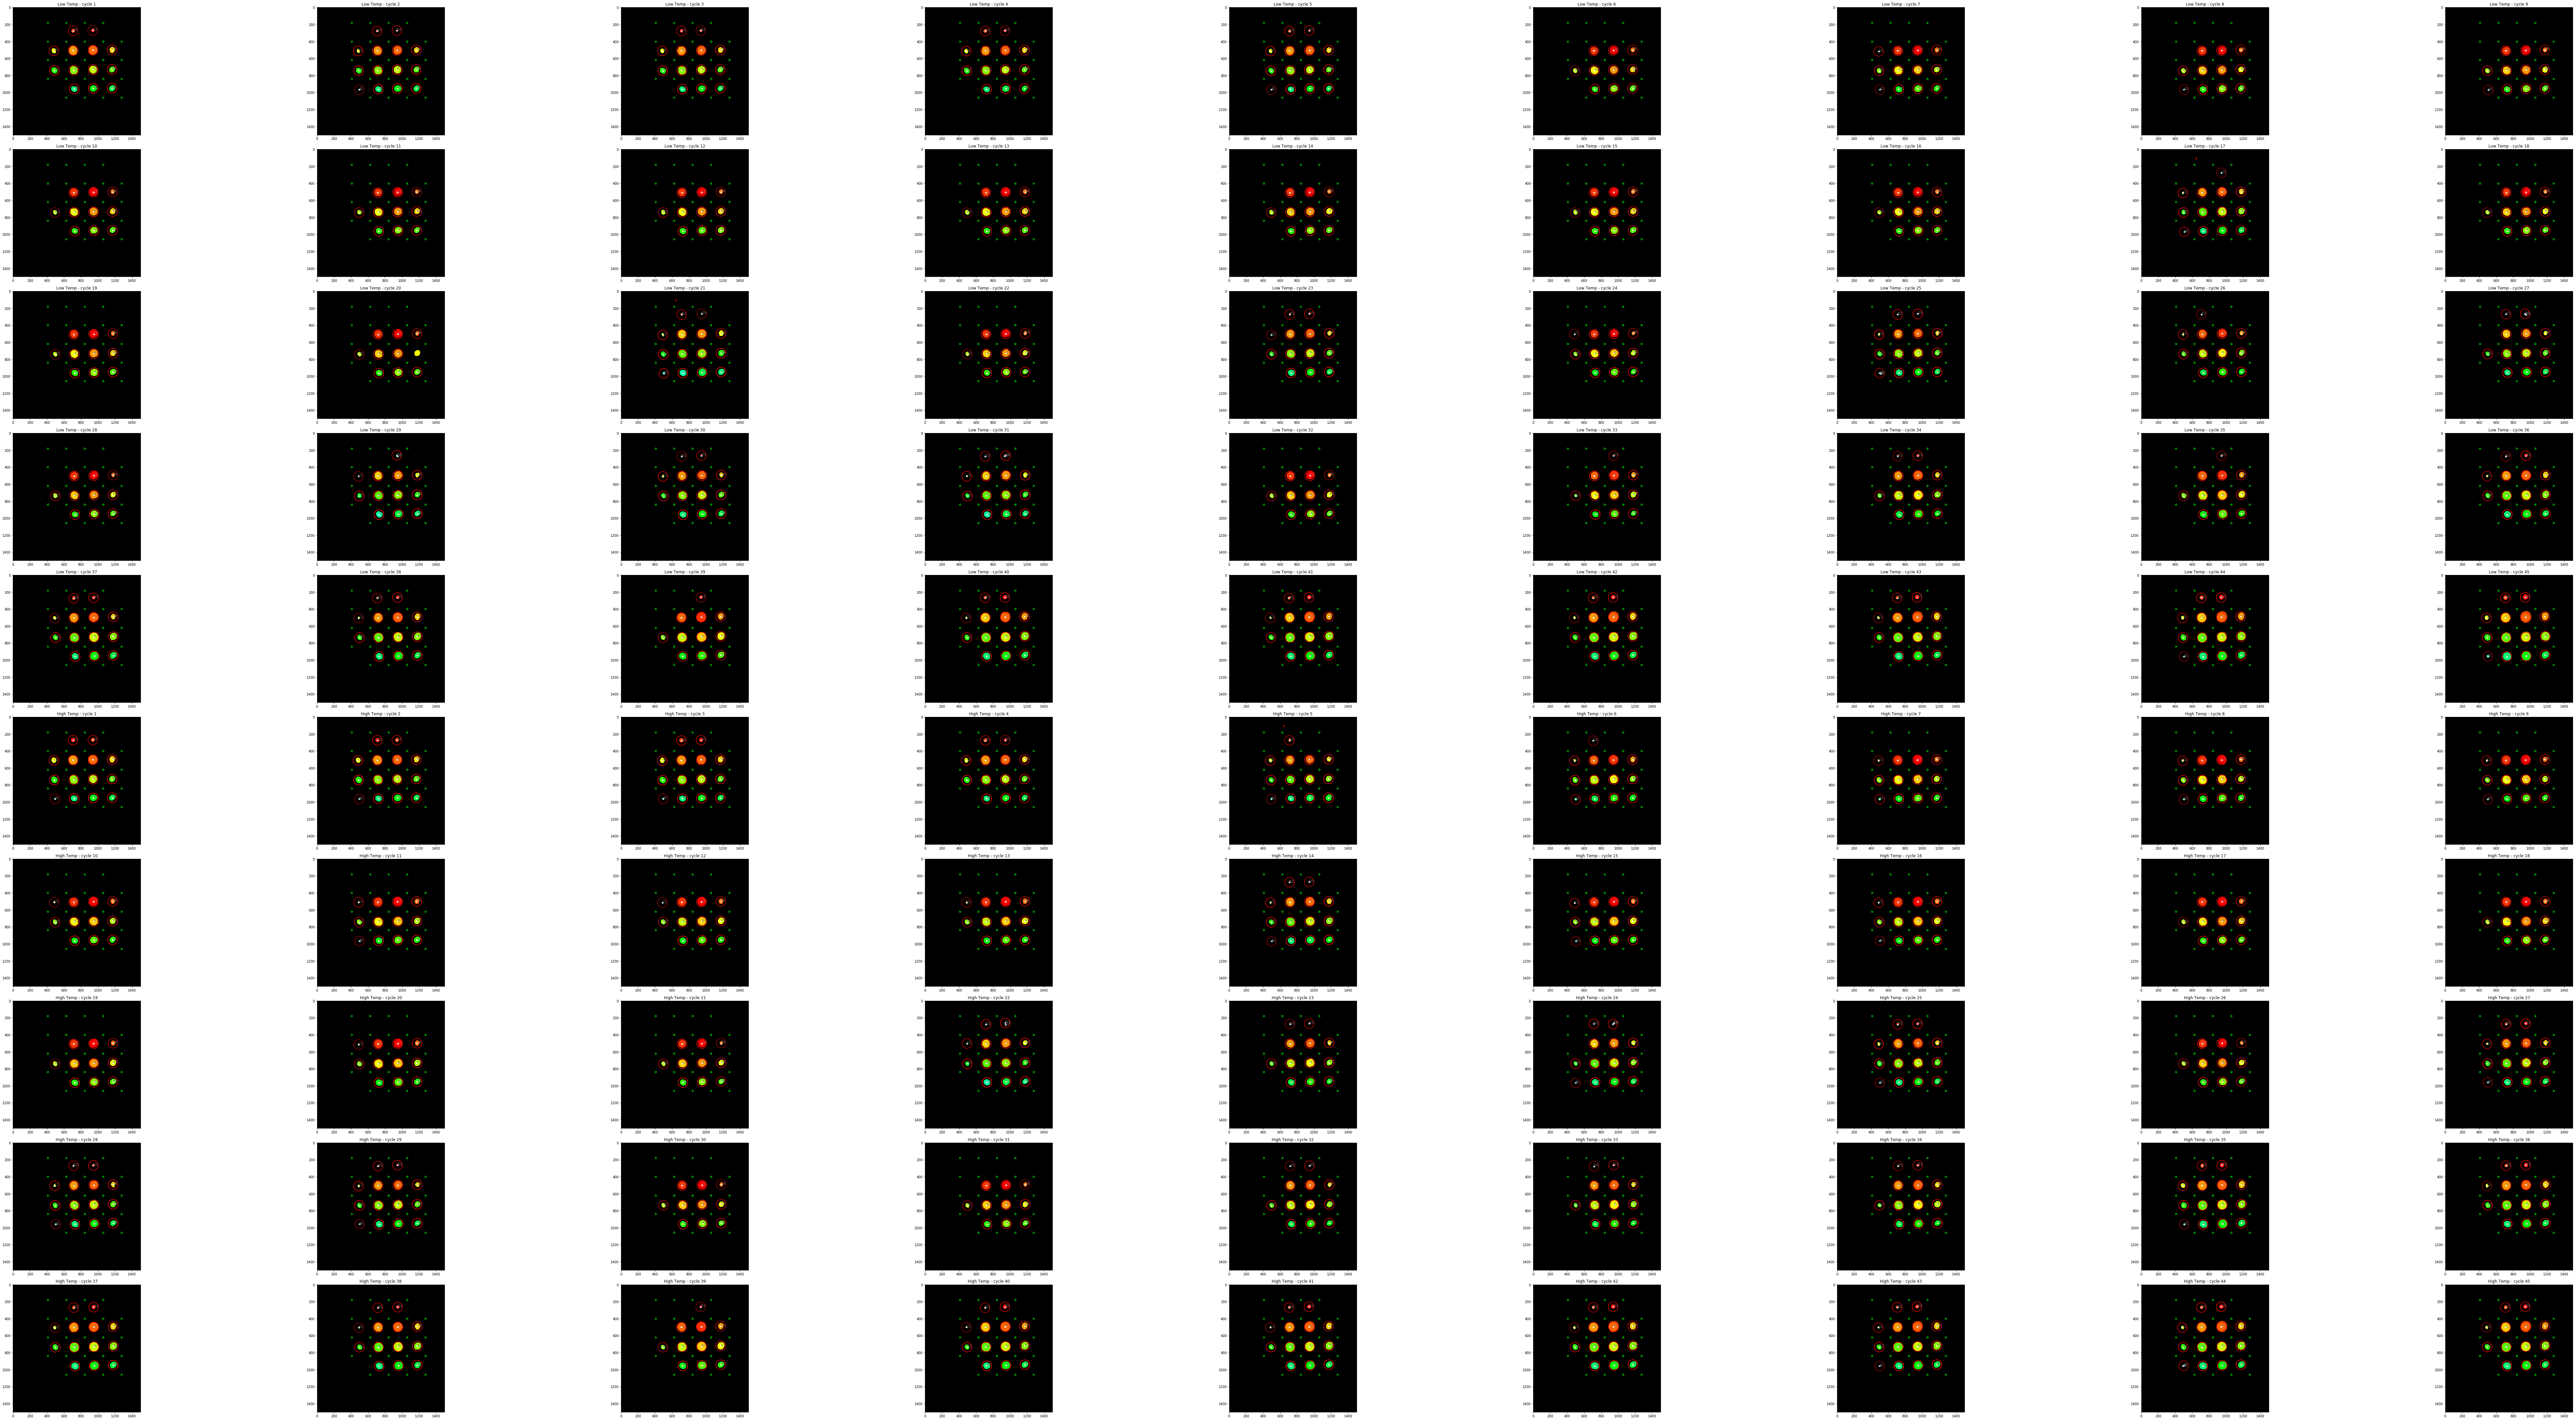

In [65]:
fig, ax = plt.subplots(10, 9, figsize=(24*5, 12*5))            
region_intensity_dict = {}
for t in range(2):
    region_intensity_dict[temp_li[t]] = {}
    for well in well_location_dict.keys():
        region_intensity_dict[temp_li[t]][well] = [0]*45

    for c in range(45):
        im_labeled = im_dict['CalRed'][temp_li[t]][c]['labeled']
        image_label_overlay = skimage.color.label2rgb(im_labeled, bg_label=0, colors=colors_li)
        ax_x_coord = c//9+(t*5)
        ax_y_coord = c%9

        ax[ax_x_coord, ax_y_coord].imshow(image_label_overlay)
        ax[ax_x_coord, ax_y_coord].set_title(f'{temp_li[t]} - cycle {c+1}')
        ax[ax_x_coord, ax_y_coord].scatter(pts_x, pts_y, c='g')

        sorted_region_key = list(im_dict['CalRed'][temp_li[t]][c]['regions'].keys())
        sorted_region_key.sort(reverse=True)

        center_at_cycle = {}
        circle_li = []
        for key in sorted_region_key:
            region_obj = im_dict['CalRed'][temp_li[t]][c]['regions'][key]
            y, x = region_obj.centroid
            grid = get_grid_loc(x, y, result_dict['well_grid'][temp_li[t]]['CalRed'])
            if grid is None:
                continue

            if grid not in center_at_cycle.keys():
                center = [x, y]
                center_at_cycle[grid] = center

                y_min, x_min, y_max, x_max = well_location_dict[grid]
                grid_center_x = (x_max-x_min)/2 + x_min
                rad = grid_center_x - x_min - 50
                circle_li.append(_patches.Circle(center, radius=rad, color='r', fill=False, linewidth=1))
            else:
                center = center_at_cycle[grid]
            well = get_well_loc(x, y, center, result_dict['well_grid'][temp_li[t]]['CalRed'])

            if well is not None:
                val = region_intensity_dict[temp_li[t]][well][c]
                val += region_obj.intensity_image.sum()
                region_intensity_dict[temp_li[t]][well][c] = val

                ax[ax_x_coord, ax_y_coord].plot(x, y, color='white', marker='*')
                ax[ax_x_coord, ax_y_coord].text(x, y, well, color='gray')
            else:
                ax[ax_x_coord, ax_y_coord].plot(x, y, color='b', marker='x')
            for circle in circle_li:
                ax[ax_x_coord, ax_y_coord].add_artist(circle)

plt.tight_layout()
plt.savefig('hsv_otsu_camera2_calRed_circle.png')
plt.show()

In [67]:
im_dict['CalRed'][temp_li[0]][7]['orig']

KeyError: 'orig'

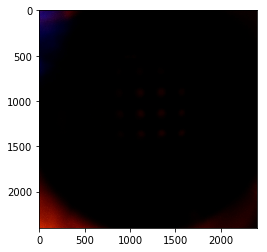

In [68]:
fpath = im_dir/'7_0_0.jpg'
im = np.array(Image.open(fpath))
plt.imshow(im)

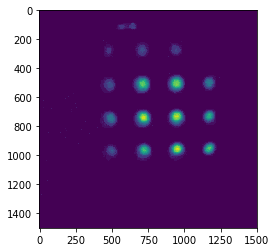

In [69]:
im_cropped = im[x_range, y_range]

im_hsv = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2HSV)
im_gray = im_hsv[:, :, 2]
plt.imshow(im_gray)

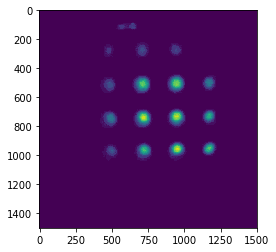

In [72]:
im_cropped = im[x_range, y_range]
plt.imshow(im_cropped[:, :, 0])

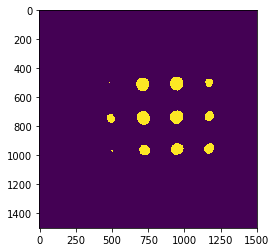

In [74]:
plt.imshow(im_dict['CalRed'][temp_li[0]][7]['thresh'])

# High HEX